# Experimentos 

## Ferramentas

- Jupyter Notebook
- GCC XXXX
- Python 3.XX: venv, matplotlib, pandas, seaborn 

In [1]:
!pip install virtualenv jupyter notebook
!python3 -m virtualenv .venv
!source .venv/bin/activate
!pip install pandas matplotlib seaborn


[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: pip install --upgrade pip
created virtual environment CPython3.12.3.final.0-64 in 250ms
  creator CPython3Posix(dest=/home/arruk/riscv/.venv, clear=False, no_vcs_ignore=False, global=False)
  seeder FromAppData(download=False, pip=bundle, via=copy, app_data_dir=/home/arruk/.local/share/virtualenv)
    added seed packages: MarkupSafe==3.0.2, PyYAML==6.0.2, Send2Trash==1.8.3, anyio==4.8.0, argon2_cffi==23.1.0, argon2_cffi_bindings==21.2.0, arrow==1.3.0, asttokens==3.0.0, async_lru==2.0.4, attrs==25.1.0, babel==2.16.0, beautifulsoup4==4.12.3, bleach==6.2.0, certifi==2024.12.14, cffi==1.17.1, charset_normalizer==3.4.1, comm==0.2.2, contourpy==1.3.1, cycler==0.12.1, debugpy==1.8.12, decorator==5.1.1, defusedxml==0.7.1, distlib==0.3.9, executing==2.2.0, fastjsonschema==2.21.1, filelock==3.17.0, fonttools==4.55.6, fqdn==1.5.1, h11==0.14.0, httpcore==1.0.7, httpx==0.28.1, idna==3.10, ipykernel==6.29.5, ipython

No diretório raiz é possivel encontrar dois arquivos .md que explicam, de forma resumida, alguns pontos principais do projeto. 

De maneira geral, a simulação do processador se da através da execução de alguns código escritos em C, neste caso, existem alguns exemplos de cógidos prontos e adaptados para o atual sistema presentes no diretório SIM/FIRMWARE:

In [1]:
!ls SIM/FIRMWARE/ 

COREMARK      io.h	pipeline.ld  raystones.pipeline.elf.list
coremark.c    Makefile	PRECOMPILED  start_pipeline.S
DHRYSTONE     memcpy.c	print.c      test_rdcycle.c
dhrystones.c  perf.h	putchar.S    wait.S
errno.c       perf.S	raystones.c


Porém, antes da simulação é necessária a compilação desses para a arquitetura correta, respeitando os padrões de memória e runtime estipulados durante a criação do processador. No arquivo Makefile, presente no diretório SIM/FIRMWARE, encontra-se algumas regras que são utilizadas no processo de compilação.

In [2]:
!cat SIM/FIRMWARE/Makefile

include ../../FIRMWARE/makefile.inc
RVASFLAGS=-march=$(ARCH) -mabi=$(ABI) 
RVCFLAGS=-I. -O2 -fno-pic -march=$(ARCH) -mabi=$(ABI) -fno-stack-protector -w -Wl,--no-relax

RAM_SIZE=6144

LIBOBJECTS=putchar.o wait.o print.o memcpy.o errno.o perf.o

# DUAL MEMORY (64 kb program ROM, 64 kb data RAM)
%.pipeline.elf: %.o start_pipeline.o $(LIBOBJECTS) $(RV_BINARIES)
	$(RVLD) -T pipeline.ld -m elf32lriscv -nostdlib -norelax $< $(LIBOBJECTS) -L$(RVTOOLCHAIN_LIB_DIR) -lm $(RVTOOLCHAIN_GCC_LIB_DIR)/libgcc.a  -o $@
	$(RVOBJDUMP) -Mnumeric -D $@ > $@.list

%.PROGROM.hex: %.pipeline.elf $(FIRMWARE_DIR)/TOOLS/firmware_words 
	$(FIRMWARE_DIR)/TOOLS/firmware_words $< -ram 0x20000 -max_addr 0x20000 -out $@ -from_addr 0 -to_addr 0xFFFF
	cp $@ ../PROGROM.hex
	mkdir -p ../obj_dir
	cp $@ ../obj_dir/PROGROM.hex

%.DATARAM.hex: %.pipeline.elf $(FIRMWARE_DIR)/TOOLS/firmware_words 
	$(FIRMWARE_DIR)/TOOLS/firmware_words $< -ram 0x20000 -max_addr 0x20000 -out $@ -from_addr 0x10000 -to_addr 0x1FFFF
	cp $@ ../DATARA

Para compilar qualquer dos códigos é preciso utilizar a regra (programa).pipeline.hex, que, de acordo com o Makefile, tem como dependências a criação de dois arquivos (PROGROM.hex e DATARAM.hex) antes de realizar o script. Portanto, as regras PROGROM.hex e DATARAM.hex serão realizadas, porém, elas também possuem uma dependência do arquivo (programa).pipeline.elf. Para tanto, a ultima regra, pipeline.elf, é necessária, tendo como dependências o programa alvo compilado em arquivo objeto, o arquivo runtime, e todos os arquivos que servem como "bibliotecas" compilados também como arquivos objetos. Estas compilações são feitas através de uma regra presente no arquivo FIRMWARE/makefile.inc. Após todos, os arquivos objetos, estiverem prontos será feita a vinculação dos mesmos junto de algumas bibliotecas adicionais, ajustando também o linker script (pipeline.ld).

Voltando agora para as regras PROGROM.hex e DATARAM.hex, com o arquivo (programa).pipeline.elf pronto, serão feitas as adaptações do arquivo .elf para dois arquivos de memória formatados com 32bits de informação, em hexadecimal, por linha e escritas em ASCII. Por fim, com as dependências da regra pipeline.hex prontas é escrito no arquivo SIM/firmware.txt o programa que foi compilado.

In [3]:
!cd SIM/FIRMWARE && make test_rdcycle.pipeline.hex

../../FIRMWARE/makefile.inc:76: warning: ignoring prerequisites on suffix rule definition
../../FIRMWARE/makefile.inc:80: warning: ignoring prerequisites on suffix rule definition
../../FIRMWARE/makefile.inc:84: warning: ignoring prerequisites on suffix rule definition
/home/menotti/Workspace/learn-fpga/FemtoRV/FIRMWARE/TOOLCHAIN/riscv64-unknown-elf-gcc-8.3.0-2020.04.0-x86_64-linux-ubuntu14/bin/riscv64-unknown-elf-gcc -I. -O2 -fno-pic -march=rv32i -mabi=ilp32 -fno-stack-protector -w -Wl,--no-relax  -c test_rdcycle.c
/home/menotti/Workspace/learn-fpga/FemtoRV/FIRMWARE/TOOLCHAIN/riscv64-unknown-elf-gcc-8.3.0-2020.04.0-x86_64-linux-ubuntu14/bin/riscv64-unknown-elf-as -march=rv32i -mabi=ilp32   start_pipeline.S -o start_pipeline.o 
/home/menotti/Workspace/learn-fpga/FemtoRV/FIRMWARE/TOOLCHAIN/riscv64-unknown-elf-gcc-8.3.0-2020.04.0-x86_64-linux-ubuntu14/bin/riscv64-unknown-elf-as -march=rv32i -mabi=ilp32   putchar.S -o putchar.o 
/home/menotti/Workspace/learn-fpga/FemtoRV/FIRMWARE/TOOLCHAI

Com os arquivos DATARAM.hex e PROGROM.hex prontos é possível realizar a simulação, usando o simulador Verilator através de um testbench simples que apenas gera o clock. Para executar o simulador é preciso executar o script SIM/run_verilator.sh com a configuração desejada. O script tem 2 argumentos, o primeiro é qual implementação do processador será utilizada, e a segunda se trata do modo de execução: "v" remete à verbose e apenas simula o processador direcionando a saída para o terminal, "a" remete à all e simula todos os benchmarks disponíveis (CoreMark, Raystones e Dhrystones), direcionando a saída já filtrada para os arquivos de análise, e por fim se não houver argumento é apenas executado o programa presente nos arquivos de memória, mas também direcionando a saída para os arquivos de análise.

In [4]:
!cat SIM/run_verilator.sh

PREC="PRECOMPILED"
INFO_DIR="../INFO/BENCH"
BENCH=$(cut -d. -f 1 firmware.txt)
echo $BENCH
IMPL=$(echo $1 | cut -d. -f 1 )
IMPL_T=$IMPL
NO=$(echo "$1" | grep -Eo [0-9]+)

main() {

	(cd obj_dir; rm -f *.cpp *.o *.a VSOC)
	verilator -CFLAGS '-I../../FIRMWARE/LIBFEMTORV32 -DSTANDALONE_FEMTOELF' -DBENCH -DBOARD_FREQ=10 -DCPU_FREQ=10 -DPASSTHROUGH_PLL -Wno-fatal \
		  --top-module SOC -cc -exe bench.cpp ../../FIRMWARE/LIBFEMTORV32/femto_elf.c $1
	
	(cd obj_dir; make -f VSOC.mk)
	if [ "$2" = "v" ]
	then
		obj_dir/VSOC 
	elif [ "$2" = "a" ]
	then	
		
		cp ${PREC}/RAYSTONES/DATARAM.hex ./ && cp ${PREC}/RAYSTONES/PROGROM.hex ./
		echo "raystones.pipeline.hex" > firmware.txt
		obj_dir/VSOC > ${INFO_DIR}/temp

		branch_info
		rayst_parse
		

		cp ${PREC}/DHRYSTONES/DATARAM.hex ./ && cp ${PREC}/DHRYSTONES/PROGROM.hex ./
		echo "dhrystones.pipeline.hex" > firmware.txt
		obj_dir/VSOC > ${INFO_DIR}/temp

		branch_info
		dhry_parse

		cp ${PREC}/COREMARK/DATARAM.hex ./ && cp ${PREC}/COREMARK/PROGROM.

Execução do código test_rdcycles no processador core2.

In [5]:
!cd SIM/ && ./run_verilator.sh core2.v v

test_rdcycle
g++  -I.  -MMD -I/usr/share/verilator/include -I/usr/share/verilator/include/vltstd -DVM_COVERAGE=0 -DVM_SC=0 -DVM_TRACE=0 -faligned-new -fcf-protection=none -Wno-bool-operation -Wno-sign-compare -Wno-uninitialized -Wno-unused-but-set-variable -Wno-unused-parameter -Wno-unused-variable -Wno-shadow     -I../../FIRMWARE/LIBFEMTORV32 -DSTANDALONE_FEMTOELF  -Os -c -o femto_elf.o ../../FIRMWARE/LIBFEMTORV32/femto_elf.c
g++  -I.  -MMD -I/usr/share/verilator/include -I/usr/share/verilator/include/vltstd -DVM_COVERAGE=0 -DVM_SC=0 -DVM_TRACE=0 -faligned-new -fcf-protection=none -Wno-bool-operation -Wno-sign-compare -Wno-uninitialized -Wno-unused-but-set-variable -Wno-unused-parameter -Wno-unused-variable -Wno-shadow     -I../../FIRMWARE/LIBFEMTORV32 -DSTANDALONE_FEMTOELF  -Os -c -o bench.o ../bench.cpp
g++  -I.  -MMD -I/usr/share/verilator/include -I/usr/share/verilator/include/vltstd -DVM_COVERAGE=0 -DVM_SC=0 -DVM_TRACE=0 -faligned-new -fcf-protection=none -Wno-bool-operation -Wno

Durante a alteração de códigos, é uma boa prática realizar a limpeza de arquivos antigos através da regra clean.

In [6]:
!cd SIM/FIRMWARE && make clean

../../FIRMWARE/makefile.inc:76: warning: ignoring prerequisites on suffix rule definition
../../FIRMWARE/makefile.inc:80: warning: ignoring prerequisites on suffix rule definition
../../FIRMWARE/makefile.inc:84: warning: ignoring prerequisites on suffix rule definition
rm -f *.o *.elf *.hex *.exe *~ *.a *.bin *.list


Compilação do código raystones.c.

In [7]:
!cd SIM/FIRMWARE && make raystones.pipeline.hex

../../FIRMWARE/makefile.inc:76: warning: ignoring prerequisites on suffix rule definition
../../FIRMWARE/makefile.inc:80: warning: ignoring prerequisites on suffix rule definition
../../FIRMWARE/makefile.inc:84: warning: ignoring prerequisites on suffix rule definition
/home/menotti/Workspace/learn-fpga/FemtoRV/FIRMWARE/TOOLCHAIN/riscv64-unknown-elf-gcc-8.3.0-2020.04.0-x86_64-linux-ubuntu14/bin/riscv64-unknown-elf-gcc -I. -O2 -fno-pic -march=rv32i -mabi=ilp32 -fno-stack-protector -w -Wl,--no-relax  -c raystones.c
/home/menotti/Workspace/learn-fpga/FemtoRV/FIRMWARE/TOOLCHAIN/riscv64-unknown-elf-gcc-8.3.0-2020.04.0-x86_64-linux-ubuntu14/bin/riscv64-unknown-elf-as -march=rv32i -mabi=ilp32   start_pipeline.S -o start_pipeline.o 
/home/menotti/Workspace/learn-fpga/FemtoRV/FIRMWARE/TOOLCHAIN/riscv64-unknown-elf-gcc-8.3.0-2020.04.0-x86_64-linux-ubuntu14/bin/riscv64-unknown-elf-as -march=rv32i -mabi=ilp32   putchar.S -o putchar.o 
/home/menotti/Workspace/learn-fpga/FemtoRV/FIRMWARE/TOOLCHAIN/r

Simulação do raystones através do processador core2, feita de maneira a direcionar a saída para o terminal.

In [8]:
!cd SIM/ && ./run_verilator.sh core2.v v

raystones
g++  -I.  -MMD -I/usr/share/verilator/include -I/usr/share/verilator/include/vltstd -DVM_COVERAGE=0 -DVM_SC=0 -DVM_TRACE=0 -faligned-new -fcf-protection=none -Wno-bool-operation -Wno-sign-compare -Wno-uninitialized -Wno-unused-but-set-variable -Wno-unused-parameter -Wno-unused-variable -Wno-shadow     -I../../FIRMWARE/LIBFEMTORV32 -DSTANDALONE_FEMTOELF  -Os -c -o femto_elf.o ../../FIRMWARE/LIBFEMTORV32/femto_elf.c
g++  -I.  -MMD -I/usr/share/verilator/include -I/usr/share/verilator/include/vltstd -DVM_COVERAGE=0 -DVM_SC=0 -DVM_TRACE=0 -faligned-new -fcf-protection=none -Wno-bool-operation -Wno-sign-compare -Wno-uninitialized -Wno-unused-but-set-variable -Wno-unused-parameter -Wno-unused-variable -Wno-shadow     -I../../FIRMWARE/LIBFEMTORV32 -DSTANDALONE_FEMTOELF  -Os -c -o bench.o ../bench.cpp
g++  -I.  -MMD -I/usr/share/verilator/include -I/usr/share/verilator/include/vltstd -DVM_COVERAGE=0 -DVM_SC=0 -DVM_TRACE=0 -faligned-new -fcf-protection=none -Wno-bool-operation -Wno-si

In [9]:
!cd SIM/FIRMWARE/ && make clean

../../FIRMWARE/makefile.inc:76: warning: ignoring prerequisites on suffix rule definition
../../FIRMWARE/makefile.inc:80: warning: ignoring prerequisites on suffix rule definition
../../FIRMWARE/makefile.inc:84: warning: ignoring prerequisites on suffix rule definition
rm -f *.o *.elf *.hex *.exe *~ *.a *.bin *.list


Compilação do código dhrystones.c.

In [10]:
!cd SIM/FIRMWARE/ && make dhrystones.pipeline.hex

../../FIRMWARE/makefile.inc:76: warning: ignoring prerequisites on suffix rule definition
../../FIRMWARE/makefile.inc:80: warning: ignoring prerequisites on suffix rule definition
../../FIRMWARE/makefile.inc:84: warning: ignoring prerequisites on suffix rule definition
make: *** No rule to make target '/home/SER/Workspace/learn-fpga/FemtoRV/FIRMWARE/TOOLCHAIN/riscv64-unknown-elf-gcc-8.3.0-2020.04.0-x86_64-linux-ubuntu14/bin/riscv64-unknown-elf-as', needed by 'dhrystones.pipeline.elf'.  Stop.


Simulação do código dhrystones.c, com argumento verbose.

In [11]:
!cd SIM/ && ./run_verilator.sh core2.v v

raystones
g++  -I.  -MMD -I/usr/share/verilator/include -I/usr/share/verilator/include/vltstd -DVM_COVERAGE=0 -DVM_SC=0 -DVM_TRACE=0 -faligned-new -fcf-protection=none -Wno-bool-operation -Wno-sign-compare -Wno-uninitialized -Wno-unused-but-set-variable -Wno-unused-parameter -Wno-unused-variable -Wno-shadow     -I../../FIRMWARE/LIBFEMTORV32 -DSTANDALONE_FEMTOELF  -Os -c -o femto_elf.o ../../FIRMWARE/LIBFEMTORV32/femto_elf.c
g++  -I.  -MMD -I/usr/share/verilator/include -I/usr/share/verilator/include/vltstd -DVM_COVERAGE=0 -DVM_SC=0 -DVM_TRACE=0 -faligned-new -fcf-protection=none -Wno-bool-operation -Wno-sign-compare -Wno-uninitialized -Wno-unused-but-set-variable -Wno-unused-parameter -Wno-unused-variable -Wno-shadow     -I../../FIRMWARE/LIBFEMTORV32 -DSTANDALONE_FEMTOELF  -Os -c -o bench.o ../bench.cpp
g++  -I.  -MMD -I/usr/share/verilator/include -I/usr/share/verilator/include/vltstd -DVM_COVERAGE=0 -DVM_SC=0 -DVM_TRACE=0 -faligned-new -fcf-protection=none -Wno-bool-operation -Wno-si

In [12]:
!cd SIM/FIRMWARE && make clean

../../FIRMWARE/makefile.inc:76: warning: ignoring prerequisites on suffix rule definition
../../FIRMWARE/makefile.inc:80: warning: ignoring prerequisites on suffix rule definition
../../FIRMWARE/makefile.inc:84: warning: ignoring prerequisites on suffix rule definition
rm -f *.o *.elf *.hex *.exe *~ *.a *.bin *.list


Para a simulação do benchmar CoreMark é mais fácil a utilização do código pré-compilado presente em SIM/PRECOMPILED/COREMARK.

In [13]:
!cd SIM/PRECOMPILED/COREMARK/ && cp DATARAM.hex PROGROM.hex ../../ && echo "coremark.pipeline.hex" > ../../firmware.txt

Simulação do benchmark CoreMark, com argumento verbose.

In [14]:
!cd SIM/ && ./run_verilator.sh core2.v v

coremark
g++  -I.  -MMD -I/usr/share/verilator/include -I/usr/share/verilator/include/vltstd -DVM_COVERAGE=0 -DVM_SC=0 -DVM_TRACE=0 -faligned-new -fcf-protection=none -Wno-bool-operation -Wno-sign-compare -Wno-uninitialized -Wno-unused-but-set-variable -Wno-unused-parameter -Wno-unused-variable -Wno-shadow     -I../../FIRMWARE/LIBFEMTORV32 -DSTANDALONE_FEMTOELF  -Os -c -o femto_elf.o ../../FIRMWARE/LIBFEMTORV32/femto_elf.c
g++  -I.  -MMD -I/usr/share/verilator/include -I/usr/share/verilator/include/vltstd -DVM_COVERAGE=0 -DVM_SC=0 -DVM_TRACE=0 -faligned-new -fcf-protection=none -Wno-bool-operation -Wno-sign-compare -Wno-uninitialized -Wno-unused-but-set-variable -Wno-unused-parameter -Wno-unused-variable -Wno-shadow     -I../../FIRMWARE/LIBFEMTORV32 -DSTANDALONE_FEMTOELF  -Os -c -o bench.o ../bench.cpp
g++  -I.  -MMD -I/usr/share/verilator/include -I/usr/share/verilator/include/vltstd -DVM_COVERAGE=0 -DVM_SC=0 -DVM_TRACE=0 -faligned-new -fcf-protection=none -Wno-bool-operation -Wno-sig

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker 
from matplotlib.lines import Line2D
import seaborn as sns

<Axes: xlabel='CORE'>

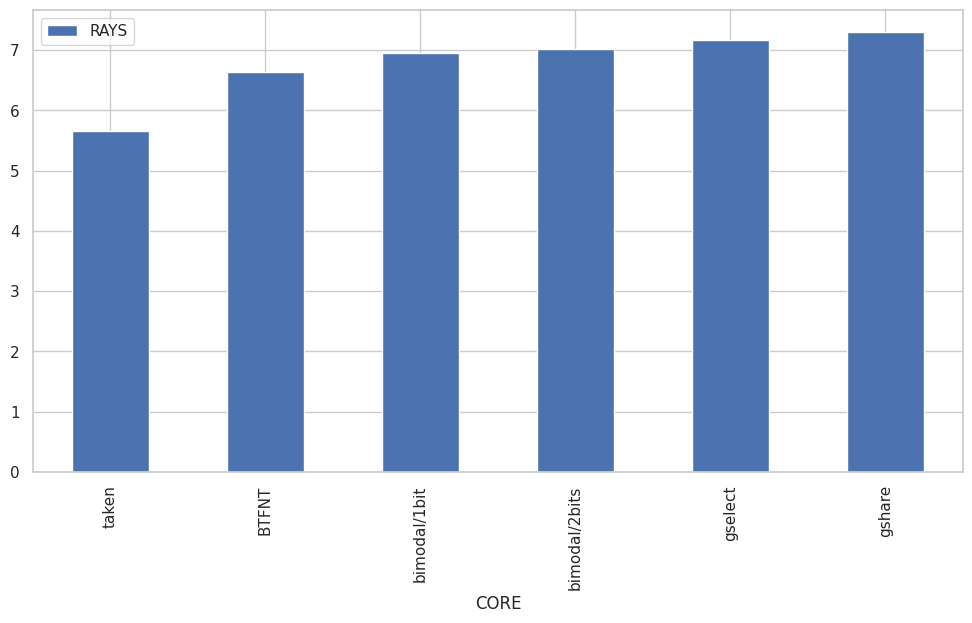

In [9]:
bench = pd.read_csv("INFO/BENCH/raystones.csv", usecols=["CORE", "RAYS"])
bench.plot(kind = "bar", x = "CORE")

<Axes: xlabel='CORE'>

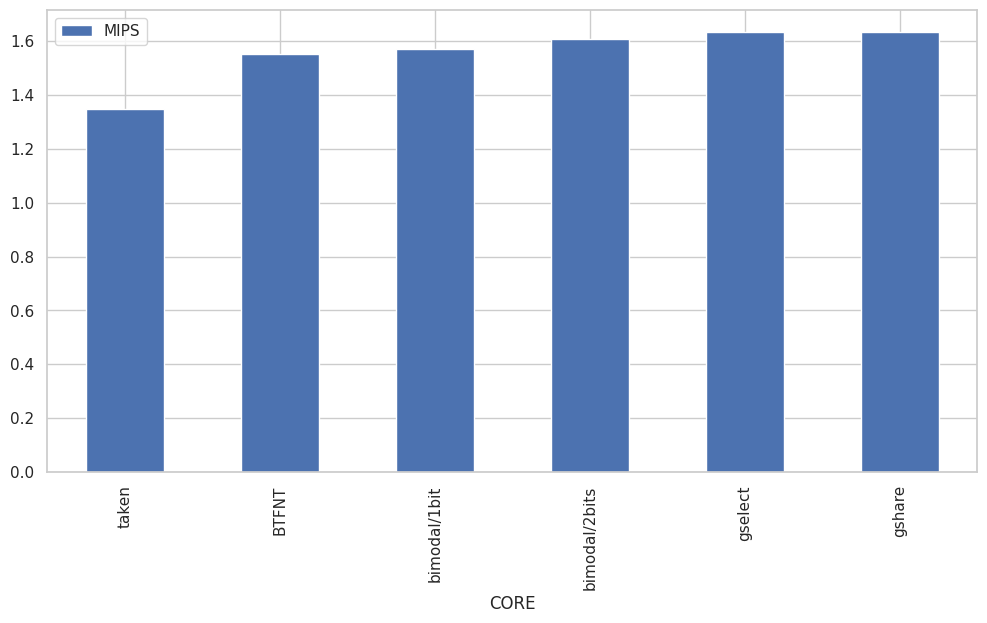

In [8]:
bench = pd.read_csv("INFO/BENCH/dhrystones.csv", usecols=["CORE", "MIPS"])
bench.plot(kind = "bar", x = "CORE")

<Axes: xlabel='CORE'>

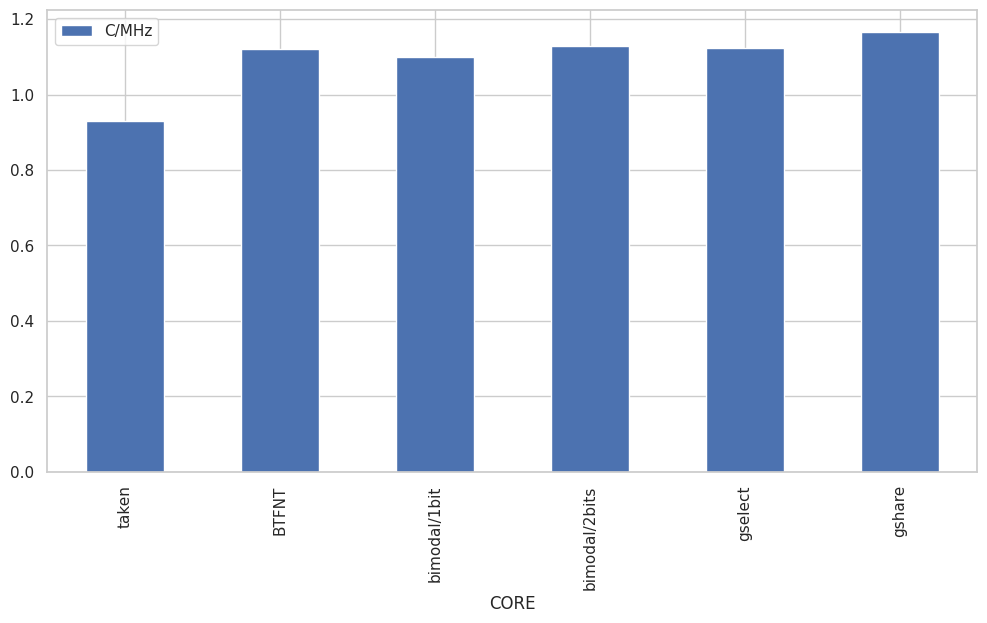

In [7]:
bench = pd.read_csv("INFO/BENCH/coremark.csv", usecols=["CORE", "C/MHz"])
bench.plot(kind = "bar", x = "CORE")

<Axes: xlabel='CORE', ylabel='DESEMPENHO'>

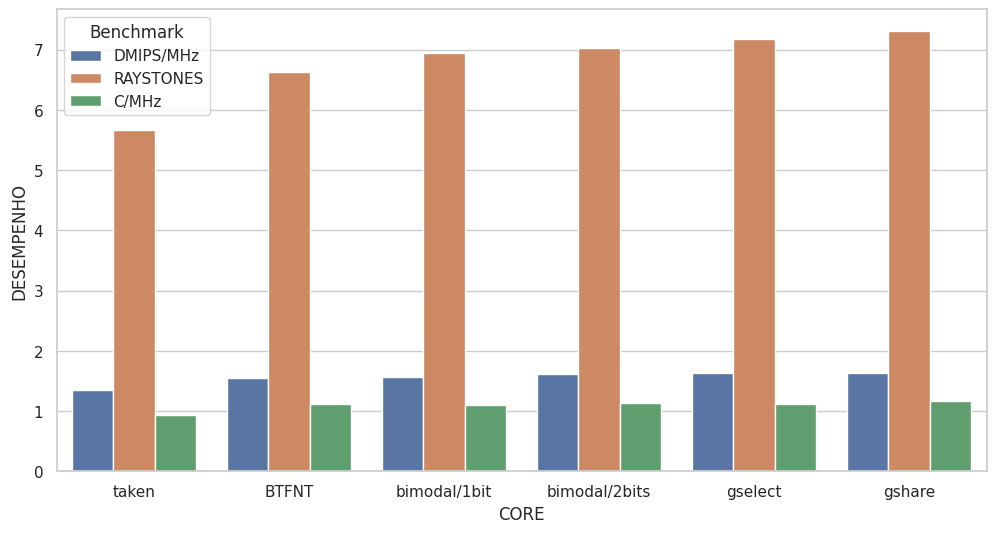

In [17]:
cols = ["CORE", "DESEMPENHO"]
df0 = pd.read_csv("INFO/BENCH/desem/dhrystones.csv", usecols=cols)
df1 = pd.read_csv("INFO/BENCH/desem/raystones.csv" , usecols=cols)
df2 = pd.read_csv("INFO/BENCH/desem/coremark.csv"  , usecols=cols)
#df3 = pd.concat([df0, df1, df2]).groupby(level=0).mean()
df0['Benchmark']="DMIPS/MHz"
df1['Benchmark']="RAYSTONES"
df2['Benchmark']="C/MHz"
#df3['Benchmark']="mean"
bench = pd.concat([df0, df1, df2])
#bench.plot(kind = "bar", x = "CORE")

#sns.lineplot(x=cols[0], y='CPI', data=bench, hue='Benchmark')
#.set(style="whitegrid", rc={"figure.figsize":(12, 6)})
sns.barplot(x=cols[0], y='DESEMPENHO', data=bench, hue='Benchmark')

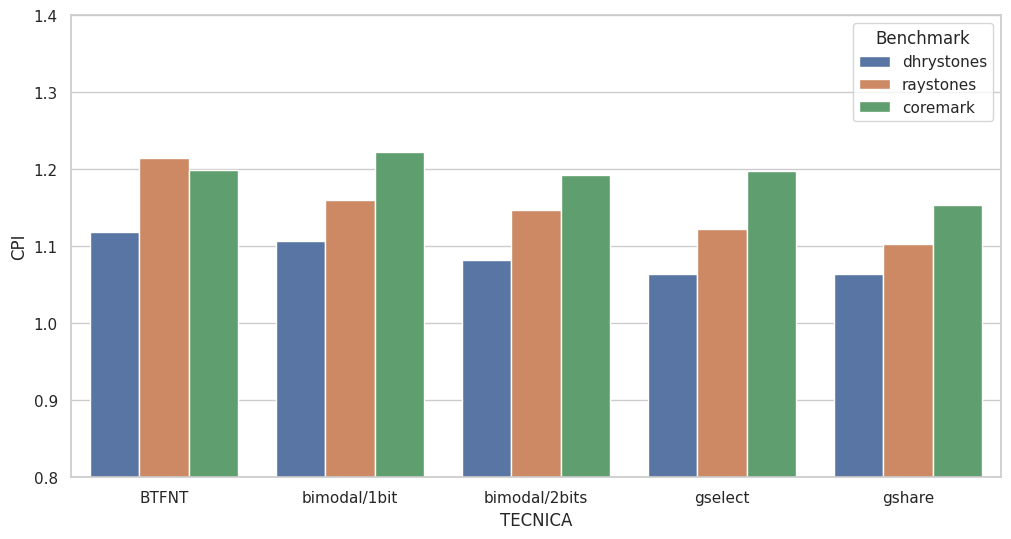

In [14]:
cols = ["TECNICA", "CPI"]
df0 = pd.read_csv("INFO/BENCH/dhrystones.csv", usecols=cols)
df1 = pd.read_csv("INFO/BENCH/raystones.csv" , usecols=cols)
df2 = pd.read_csv("INFO/BENCH/coremark.csv"  , usecols=cols)
#df3 = pd.concat([df0, df1, df2]).groupby(level=0).mean()
df0['Benchmark']="dhrystones"
df1['Benchmark']="raystones"
df2['Benchmark']="coremark"
#df3['Benchmark']="mean"
bench = pd.concat([df0, df1, df2])

#sns.lineplot(x=cols[0], y='CPI', data=bench, hue='Benchmark')
sns.set(style="whitegrid", rc={"figure.figsize":(12, 6)})
ax = sns.barplot(x=cols[0], y='CPI', data=bench, hue='Benchmark')
ax.set_ylim(0.8,1.4)

plt.savefig("cpi_model.png")


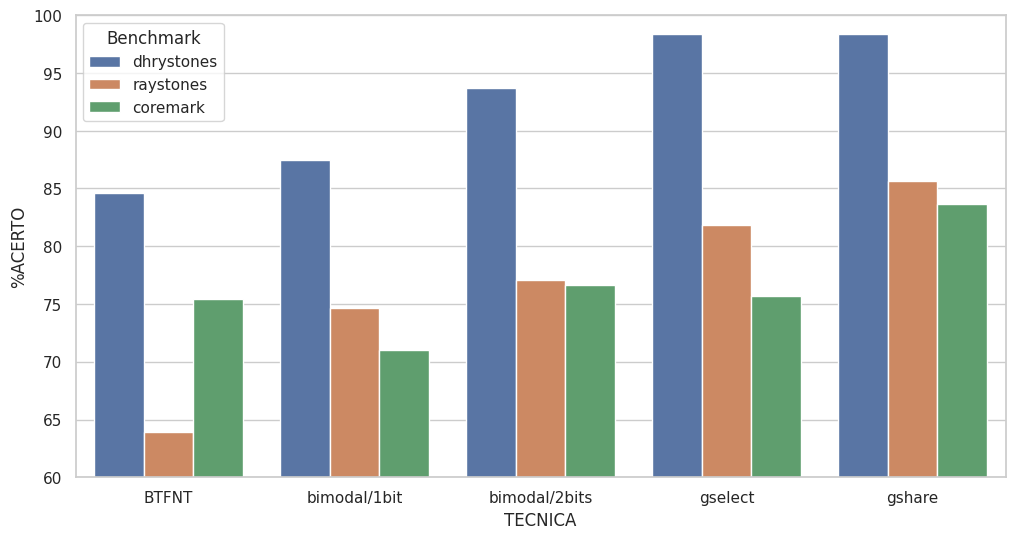

In [69]:
cols = ["TECNICA", "%ACERTO"]
df0 = pd.read_csv("INFO/BENCH/dhrystones.csv", usecols=cols)
df0['Benchmark']="dhrystones"
df1 = pd.read_csv("INFO/BENCH/raystones.csv" , usecols=cols)
df1['Benchmark']="raystones"
df2 = pd.read_csv("INFO/BENCH/coremark.csv"  , usecols=cols)
df2['Benchmark']="coremark"

bench = pd.concat([df0, df1, df2])
#bench.plot(kind = "bar", x = "CORE", y='HITS')
#sns.lineplot(x=cols[0], y='CPI', data=bench, hue='Benchmark')
#sns.set(style="whitegrid", rc={"figure.figsize":(12, 6)})
ax = sns.barplot(x=cols[0], y='%ACERTO', data=bench, hue='Benchmark')
ax.set_ylim(60,100)
plt.savefig("hits.png")

In [60]:
"""
cols = ["BHT", "CPI", "HITS"]
df0 = pd.read_csv("INFO/BENCH/core6/dhrystones.csv", usecols=cols)
df1 = pd.read_csv("INFO/BENCH/core6/raystones.csv" , usecols=cols)
df2 = pd.read_csv("INFO/BENCH/core6/coremark.csv"  , usecols=cols)
df3 = pd.concat([df0, df1, df2]).groupby(level=0).mean()
df0['Benchmark']="dhrystones"
df1['Benchmark']="raystones"
df2['Benchmark']="coremark"
df3['Benchmark']="mean"
bench = pd.concat([df0, df1, df2, df3])

sns.set(style="whitegrid", rc={"figure.figsize":(12, 6)})
ax = sns.lineplot(x=cols[0], y='CPI', data=bench, hue='Benchmark')
ax.set(xticks=df0['BHT'])
"""

'\ncols = ["BHT", "CPI", "HITS"]\ndf0 = pd.read_csv("INFO/BENCH/core6/dhrystones.csv", usecols=cols)\ndf1 = pd.read_csv("INFO/BENCH/core6/raystones.csv" , usecols=cols)\ndf2 = pd.read_csv("INFO/BENCH/core6/coremark.csv"  , usecols=cols)\ndf3 = pd.concat([df0, df1, df2]).groupby(level=0).mean()\ndf0[\'Benchmark\']="dhrystones"\ndf1[\'Benchmark\']="raystones"\ndf2[\'Benchmark\']="coremark"\ndf3[\'Benchmark\']="mean"\nbench = pd.concat([df0, df1, df2, df3])\n\nsns.set(style="whitegrid", rc={"figure.figsize":(12, 6)})\nax = sns.lineplot(x=cols[0], y=\'CPI\', data=bench, hue=\'Benchmark\')\nax.set(xticks=df0[\'BHT\'])\n'

In [59]:
"""
cols = ["BHT", "CPI", "HITS"]
df0 = pd.read_csv("INFO/BENCH/core7/dhrystones.csv", usecols=cols)
df1 = pd.read_csv("INFO/BENCH/core7/raystones.csv" , usecols=cols)
df2 = pd.read_csv("INFO/BENCH/core7/coremark.csv"  , usecols=cols)
df3 = pd.concat([df0, df1, df2]).groupby(level=0).mean()
df0['Benchmark']="dhrystones"
df1['Benchmark']="raystones"
df2['Benchmark']="coremark"
df3['Benchmark']="mean"
bench = pd.concat([df0, df1, df2, df3])

sns.set(style="whitegrid", rc={"figure.figsize":(12, 6)})
ax = sns.lineplot(x=cols[0], y='CPI', data=bench, hue='Benchmark')
ax.set(xticks=df0['BHT'])
"""

'\ncols = ["BHT", "CPI", "HITS"]\ndf0 = pd.read_csv("INFO/BENCH/core7/dhrystones.csv", usecols=cols)\ndf1 = pd.read_csv("INFO/BENCH/core7/raystones.csv" , usecols=cols)\ndf2 = pd.read_csv("INFO/BENCH/core7/coremark.csv"  , usecols=cols)\ndf3 = pd.concat([df0, df1, df2]).groupby(level=0).mean()\ndf0[\'Benchmark\']="dhrystones"\ndf1[\'Benchmark\']="raystones"\ndf2[\'Benchmark\']="coremark"\ndf3[\'Benchmark\']="mean"\nbench = pd.concat([df0, df1, df2, df3])\n\nsns.set(style="whitegrid", rc={"figure.figsize":(12, 6)})\nax = sns.lineplot(x=cols[0], y=\'CPI\', data=bench, hue=\'Benchmark\')\nax.set(xticks=df0[\'BHT\'])\n'

In [57]:
"""
cols = ["BHT", "CPI", "HITS"]
df0 = pd.read_csv("INFO/BENCH/core8/dhrystones.csv", usecols=cols)
df1 = pd.read_csv("INFO/BENCH/core8/raystones.csv" , usecols=cols)
df2 = pd.read_csv("INFO/BENCH/core8/coremark.csv"  , usecols=cols)
df3 = pd.concat([df0, df1, df2]).groupby(level=0).mean()
df0['Benchmark']="dhrystones"
df1['Benchmark']="raystones"
df2['Benchmark']="coremark"
df3['Benchmark']="mean"
bench = pd.concat([df0, df1, df2, df3])

sns.set(style="whitegrid", rc={"figure.figsize":(12, 6)})
ax = sns.lineplot(x=cols[0], y='CPI', data=bench, hue='Benchmark')
ax.set(xticks=df0['BHT'])
"""

'\ncols = ["BHT", "CPI", "HITS"]\ndf0 = pd.read_csv("INFO/BENCH/core8/dhrystones.csv", usecols=cols)\ndf1 = pd.read_csv("INFO/BENCH/core8/raystones.csv" , usecols=cols)\ndf2 = pd.read_csv("INFO/BENCH/core8/coremark.csv"  , usecols=cols)\ndf3 = pd.concat([df0, df1, df2]).groupby(level=0).mean()\ndf0[\'Benchmark\']="dhrystones"\ndf1[\'Benchmark\']="raystones"\ndf2[\'Benchmark\']="coremark"\ndf3[\'Benchmark\']="mean"\nbench = pd.concat([df0, df1, df2, df3])\n\nsns.set(style="whitegrid", rc={"figure.figsize":(12, 6)})\nax = sns.lineplot(x=cols[0], y=\'CPI\', data=bench, hue=\'Benchmark\')\nax.set(xticks=df0[\'BHT\'])\n'

[[<matplotlib.axis.XTick at 0x7383a050fbb0>,

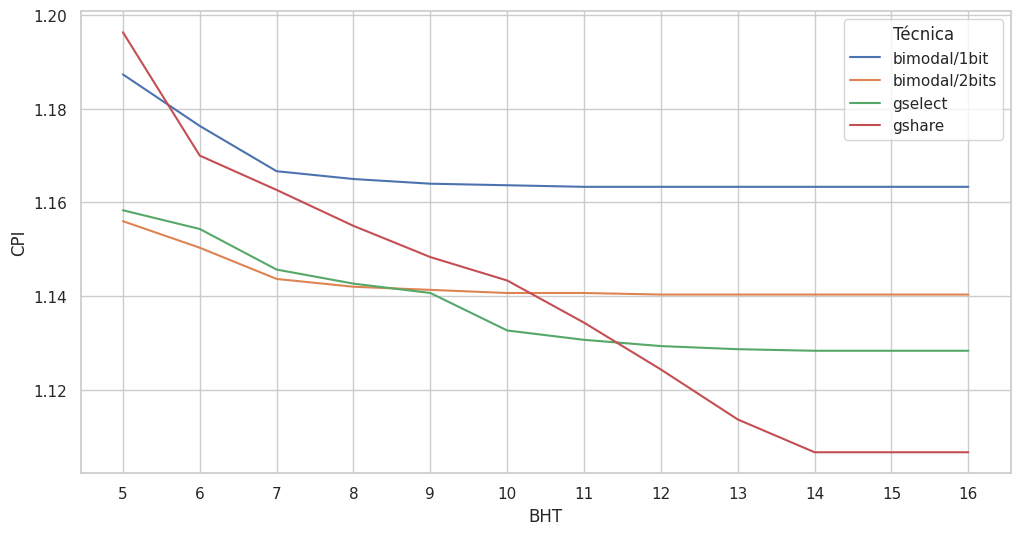

In [31]:
cols = ["BHT", "CPI", "HITS"]
df0 = pd.read_csv("INFO/BENCH/core5/dhrystones.csv", usecols=cols)
df1 = pd.read_csv("INFO/BENCH/core5/raystones.csv" , usecols=cols)
df2 = pd.read_csv("INFO/BENCH/core5/coremark.csv"  , usecols=cols)
dfc5 = pd.concat([df0, df1, df2]).groupby(level=0).mean()
dfc5['Técnica']="bimodal/1bit"
df0 = pd.read_csv("INFO/BENCH/core6/dhrystones.csv", usecols=cols)
df1 = pd.read_csv("INFO/BENCH/core6/raystones.csv" , usecols=cols)
df2 = pd.read_csv("INFO/BENCH/core6/coremark.csv"  , usecols=cols)
dfc6 = pd.concat([df0, df1, df2]).groupby(level=0).mean()
dfc6['Técnica']="bimodal/2bits"
df0 = pd.read_csv("INFO/BENCH/core7/dhrystones.csv", usecols=cols)
df1 = pd.read_csv("INFO/BENCH/core7/raystones.csv" , usecols=cols)
df2 = pd.read_csv("INFO/BENCH/core7/coremark.csv"  , usecols=cols)
dfc7 = pd.concat([df0, df1, df2]).groupby(level=0).mean()
dfc7['Técnica']="gselect"
df0 = pd.read_csv("INFO/BENCH/core8/dhrystones.csv", usecols=cols)
df1 = pd.read_csv("INFO/BENCH/core8/raystones.csv" , usecols=cols)
df2 = pd.read_csv("INFO/BENCH/core8/coremark.csv"  , usecols=cols)
dfc8 = pd.concat([df0, df1, df2]).groupby(level=0).mean()
dfc8['Técnica']="gshare"
bench = pd.concat([dfc5, dfc6, dfc7, dfc8])
bench.head()

sns.set(style="whitegrid", rc={"figure.figsize":(12, 6)})

ax = sns.lineplot(x=cols[0], y='CPI', data=bench, hue='Técnica')
ax.set(xticks=df0['BHT'])

In [31]:



cols = ["BHT", "CPI", "%ACERTO"]
df0 = pd.read_csv("INFO/BENCH/core5/dhrystones.csv", usecols=cols)
df1 = pd.read_csv("INFO/BENCH/core5/raystones.csv" , usecols=cols)
df2 = pd.read_csv("INFO/BENCH/core5/coremark.csv"  , usecols=cols)
dfc5 = pd.concat([df0, df1, df2]).groupby(level=0).mean()
dfc5['Técnica']="bimodal/1bit"
df0 = pd.read_csv("INFO/BENCH/core6/dhrystones.csv", usecols=cols)
df1 = pd.read_csv("INFO/BENCH/core6/raystones.csv" , usecols=cols)
df2 = pd.read_csv("INFO/BENCH/core6/coremark.csv"  , usecols=cols)
dfc6 = pd.concat([df0, df1, df2]).groupby(level=0).mean()
dfc6['Técnica']="bimodal/2bits"
df0 = pd.read_csv("INFO/BENCH/core7/dhrystones.csv", usecols=cols)
df1 = pd.read_csv("INFO/BENCH/core7/raystones.csv" , usecols=cols)
df2 = pd.read_csv("INFO/BENCH/core7/coremark.csv"  , usecols=cols)
dfc7 = pd.concat([df0, df1, df2]).groupby(level=0).mean()
dfc7['Técnica']="gselect"
df0 = pd.read_csv("INFO/BENCH/core8/dhrystones.csv", usecols=cols)
df1 = pd.read_csv("INFO/BENCH/core8/raystones.csv" , usecols=cols)
df2 = pd.read_csv("INFO/BENCH/core8/coremark.csv"  , usecols=cols)
dfc8 = pd.concat([df0, df1, df2]).groupby(level=0).mean()
dfc8['Técnica']="gshare"
bench = pd.concat([dfc5, dfc6, dfc7, dfc8])

sns.set(style="whitegrid", rc={"figure.figsize":(12, 6)})

ax = sns.lineplot(x='BHT', y='%ACERTO', data=bench, hue='Técnica')
ax.set(xticks=df0['BHT'])
#ax.set_ylim(70,90)
#ax.legend(loc='upper left')

plt.savefig("hits_bht.png")

FileNotFoundError: [Errno 2] No such file or directory: 'INFO/BENCH/core5/dhrystones.csv'

In [ ]:
"""
cols = ["BHT", "CPI", "HITS"]
df0 = pd.read_csv("INFO/BENCH/core5/dhrystones.csv", usecols=cols)
df1 = pd.read_csv("INFO/BENCH/core5/raystones.csv" , usecols=cols)
df2 = pd.read_csv("INFO/BENCH/core5/coremark.csv"  , usecols=cols)
dfc5 = pd.concat([df0, df1, df2]).groupby(level=0).mean()
dfc5['IMPLM']="unimodal"
df0 = pd.read_csv("INFO/BENCH/core6/dhrystones.csv", usecols=cols)
df1 = pd.read_csv("INFO/BENCH/core6/raystones.csv" , usecols=cols)
df2 = pd.read_csv("INFO/BENCH/core6/coremark.csv"  , usecols=cols)
dfc6 = pd.concat([df0, df1, df2]).groupby(level=0).mean()
dfc6['IMPLM']="bimodal"
df0 = pd.read_csv("INFO/BENCH/core7/dhrystones.csv", usecols=cols)
df1 = pd.read_csv("INFO/BENCH/core7/raystones.csv" , usecols=cols)
df2 = pd.read_csv("INFO/BENCH/core7/coremark.csv"  , usecols=cols)
dfc7 = pd.concat([df0, df1, df2]).groupby(level=0).mean()
dfc7['IMPLM']="gselect"
df0 = pd.read_csv("INFO/BENCH/core8/dhrystones.csv", usecols=cols)
df1 = pd.read_csv("INFO/BENCH/core8/raystones.csv" , usecols=cols)
df2 = pd.read_csv("INFO/BENCH/core8/coremark.csv"  , usecols=cols)
dfc8 = pd.concat([df0, df1, df2]).groupby(level=0).mean()
dfc8['IMPLM']="gshare"
bench = pd.concat([dfc8])

g = sns.lineplot(x=cols[0], y='HITS', data=bench, hue='IMPLM',  color="g")
sns.lineplot(x=cols[0], y='CPI',data=bench, ax=g.axes.twinx(), hue='IMPLM',  color="b")
g.set(xticks=dfc8['BHT'])
#g.legend(handles=[Line2D([], [], marker='_', color="g", label='column1'), Line2D([], [], marker='_', color="b", label='column2')])
"""

# SUPERESCALAR



In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as ticker 
from matplotlib.lines import Line2D
import seaborn as sns

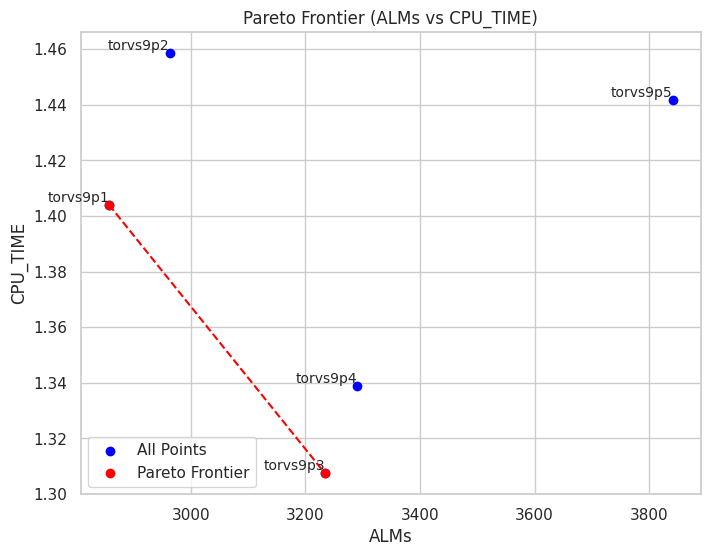

In [27]:
# Load CSV files
dfD = pd.read_csv("INFO/BENCH/TORVS/dhrystones.csv", usecols=["CPU", "CPI", "INSTRET"], nrows=10)
dfR = pd.read_csv("INFO/BENCH/TORVS/raystones.csv", usecols=["CPU", "CPI", "INSTRET"], nrows=10)
dfC = pd.read_csv("INFO/BENCH/TORVS/coremark.csv", usecols=["CPU", "CPI", "INSTRET"], nrows=10)
df0 = pd.read_csv("INFO/BOARDS/DE10S/dhrystones.csv", usecols=["CPU", "ALMs"], nrows=10)
df2 = pd.read_csv("INFO/BOARDS/DE10S/dhrystones.csv", usecols=["CPU", "FMAX1"], nrows=10)
# Compute average CPI and INSTRET across dfD, dfR, and dfC
df_avg = dfD[["CPU"]].copy()
df_avg["CPI"] = (dfD["CPI"] + dfR["CPI"] + dfC["CPI"]) / 3
df_avg["INSTRET"] = (dfD["INSTRET"] + dfR["INSTRET"] + dfC["INSTRET"]) / 3

# Calculate CPU_TIME using the averaged values
df2 = pd.merge(df2, df_avg, on="CPU", how="inner")
df2["CPU_TIME"] = (df2["CPI"] * df2["INSTRET"]) / (df2["FMAX1"] * pow(10, 6))

# Merge dataframes to include ALMs and CPU_TIME
data = pd.merge(df0, df2[["CPU", "CPU_TIME"]], on="CPU", how="inner")

# Filter rows where CPU starts with "torvs8p"
data = data[data["CPU"].str.startswith("torvs9p")]

# Extract values for ALMs and CPU_TIME
points = data[["ALMs", "CPU_TIME"]].values

# Function to identify Pareto frontier (minimizing both dimensions)
def identify_pareto(data):
    """Identify Pareto frontier points for minimization."""
    pareto = np.ones(data.shape[0], dtype=bool)  # Start with all points as True
    for i, point in enumerate(data):
        if pareto[i]:  # Only evaluate points not already dominated
            # Check if there is any point that is strictly better in both dimensions
            for j, other_point in enumerate(data):
                if (other_point[0] < point[0] and other_point[1] < point[1]):
                    pareto[i] = False
                    break  # No need to check further if point i is dominated
    return data[pareto]

# Identify Pareto optimal points
pareto_front = identify_pareto(points)

# Plot results
plt.figure(figsize=(8, 6))
plt.scatter(points[:, 0], points[:, 1], label="All Points", color="blue")
plt.scatter(pareto_front[:, 0], pareto_front[:, 1], label="Pareto Frontier", color="red")
plt.plot(pareto_front[:, 0], pareto_front[:, 1], linestyle="--", color="red")

# Add labels for points
for i in range(len(data)):
    plt.text(points[i, 0], points[i, 1], data["CPU"].iloc[i], fontsize=10, ha="right", va="bottom")

plt.xlabel("ALMs")
plt.ylabel("CPU_TIME")
plt.title("Pareto Frontier (ALMs vs CPU_TIME)")
plt.legend()
plt.grid(True)
plt.show()


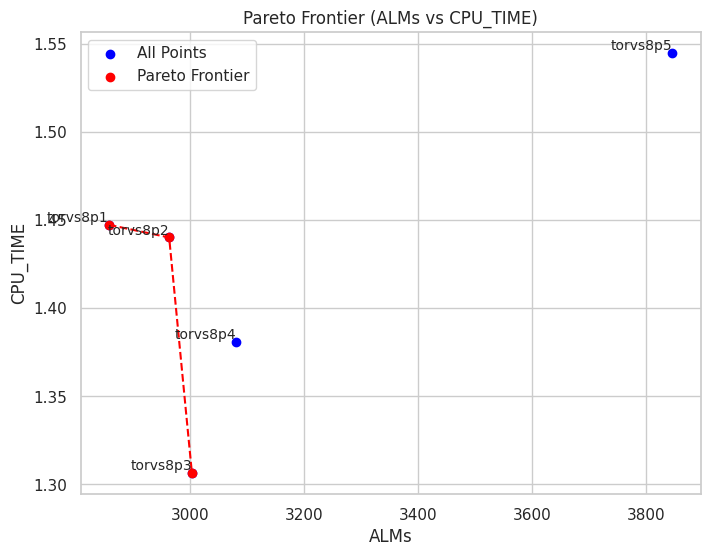

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load CSV files
dfD = pd.read_csv("INFO/BENCH/TORVS/dhrystones.csv", usecols=["CPU", "CPI", "INSTRET"], nrows=10)
dfR = pd.read_csv("INFO/BENCH/TORVS/raystones.csv", usecols=["CPU", "CPI", "INSTRET"], nrows=10)
dfC = pd.read_csv("INFO/BENCH/TORVS/coremark.csv", usecols=["CPU", "CPI", "INSTRET"], nrows=10)
df0 = pd.read_csv("INFO/BOARDS/DE10S/dhrystones.csv", usecols=["CPU", "ALMs"], nrows=10)
df2 = pd.read_csv("INFO/BOARDS/DE10S/dhrystones.csv", usecols=["CPU", "FMAX1"], nrows=10)
# Compute average CPI and INSTRET across dfD, dfR, and dfC
df_avg = dfD[["CPU"]].copy()
df_avg["CPI"] = (dfD["CPI"] + dfR["CPI"] + dfC["CPI"]) / 3
df_avg["INSTRET"] = (dfD["INSTRET"] + dfR["INSTRET"] + dfC["INSTRET"]) / 3

# Calculate CPU_TIME using the averaged values
df2 = pd.merge(df2, df_avg, on="CPU", how="inner")
df2["CPU_TIME"] = (df2["CPI"] * df2["INSTRET"]) / (df2["FMAX1"] * pow(10, 6))

# Merge dataframes to include ALMs and CPU_TIME
data = pd.merge(df0, df2[["CPU", "CPU_TIME"]], on="CPU", how="inner")

# Filter rows where CPU starts with "torvs8p"
data = data[data["CPU"].str.startswith("torvs8p")]

# Extract values for ALMs and CPU_TIME
points = data[["ALMs", "CPU_TIME"]].values

# Function to identify Pareto frontier (minimizing both dimensions)
def identify_pareto(data):
    """Identify Pareto frontier points for minimization."""
    pareto = np.ones(data.shape[0], dtype=bool)  # Start with all points as True
    for i, point in enumerate(data):
        if pareto[i]:  # Only evaluate points not already dominated
            # Check if there is any point that is strictly better in both dimensions
            for j, other_point in enumerate(data):
                if (other_point[0] < point[0] and other_point[1] < point[1]):
                    pareto[i] = False
                    break  # No need to check further if point i is dominated
    return data[pareto]

# Identify Pareto optimal points
pareto_front = identify_pareto(points)

# Plot results
plt.figure(figsize=(8, 6))
plt.scatter(points[:, 0], points[:, 1], label="All Points", color="blue")
plt.scatter(pareto_front[:, 0], pareto_front[:, 1], label="Pareto Frontier", color="red")
plt.plot(pareto_front[:, 0], pareto_front[:, 1], linestyle="--", color="red")

# Add labels for points
for i in range(len(data)):
    plt.text(points[i, 0], points[i, 1], data["CPU"].iloc[i], fontsize=10, ha="right", va="bottom")

plt.xlabel("ALMs")
plt.ylabel("CPU_TIME")
plt.title("Pareto Frontier (ALMs vs CPU_TIME)")
plt.legend()
plt.grid(True)
plt.show()

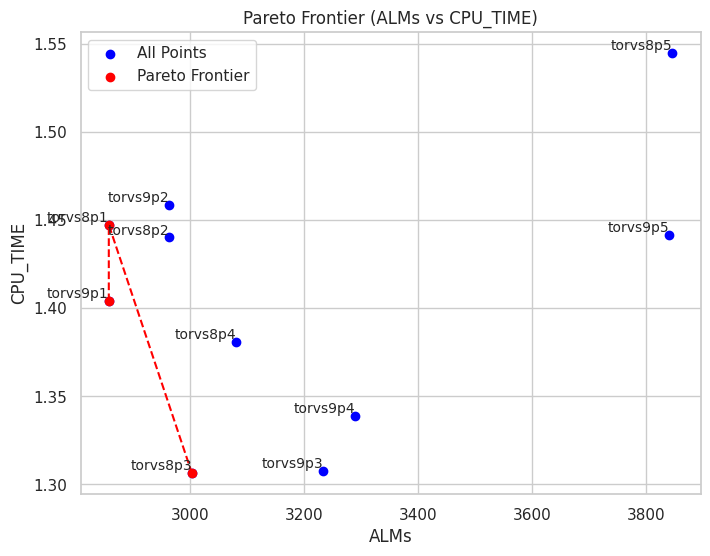

In [29]:
# Load CSV files
dfD = pd.read_csv("INFO/BENCH/TORVS/dhrystones.csv", usecols=["CPU", "CPI", "INSTRET"], nrows=10)
dfR = pd.read_csv("INFO/BENCH/TORVS/raystones.csv", usecols=["CPU", "CPI", "INSTRET"], nrows=10)
dfC = pd.read_csv("INFO/BENCH/TORVS/coremark.csv", usecols=["CPU", "CPI", "INSTRET"], nrows=10)
df0 = pd.read_csv("INFO/BOARDS/DE10S/dhrystones.csv", usecols=["CPU", "ALMs"], nrows=10)
df2 = pd.read_csv("INFO/BOARDS/DE10S/dhrystones.csv", usecols=["CPU", "FMAX1"], nrows=10)
# Compute average CPI and INSTRET across dfD, dfR, and dfC
df_avg = dfD[["CPU"]].copy()
df_avg["CPI"] = (dfD["CPI"] + dfR["CPI"] + dfC["CPI"]) / 3
df_avg["INSTRET"] = (dfD["INSTRET"] + dfR["INSTRET"] + dfC["INSTRET"]) / 3

# Calculate CPU_TIME using the averaged values
df2 = pd.merge(df2, df_avg, on="CPU", how="inner")
df2["CPU_TIME"] = (df2["CPI"] * df2["INSTRET"]) / (df2["FMAX1"] * pow(10, 6))

# Merge dataframes to include ALMs and CPU_TIME
data = pd.merge(df0, df2[["CPU", "CPU_TIME"]], on="CPU", how="inner")

# Filter rows where CPU starts with "torvs8p"
#data = data[data["CPU"].str.startswith("torvs8p")]

# Extract values for ALMs and CPU_TIME
points = data[["ALMs", "CPU_TIME"]].values

# Function to identify Pareto frontier (minimizing both dimensions)
def identify_pareto(data):
    """Identify Pareto frontier points for minimization."""
    pareto = np.ones(data.shape[0], dtype=bool)  # Start with all points as True
    for i, point in enumerate(data):
        if pareto[i]:  # Only evaluate points not already dominated
            # Check if there is any point that is strictly better in both dimensions
            for j, other_point in enumerate(data):
                if (other_point[0] < point[0] and other_point[1] < point[1]):
                    pareto[i] = False
                    break  # No need to check further if point i is dominated
    return data[pareto]

# Identify Pareto optimal points
pareto_front = identify_pareto(points)

# Plot results
plt.figure(figsize=(8, 6))
plt.scatter(points[:, 0], points[:, 1], label="All Points", color="blue")
plt.scatter(pareto_front[:, 0], pareto_front[:, 1], label="Pareto Frontier", color="red")
plt.plot(pareto_front[:, 0], pareto_front[:, 1], linestyle="--", color="red")

# Add labels for points
for i in range(len(data)):
    plt.text(points[i, 0], points[i, 1], data["CPU"].iloc[i], fontsize=10, ha="right", va="bottom")

plt.xlabel("ALMs")
plt.ylabel("CPU_TIME")
plt.title("Pareto Frontier (ALMs vs CPU_TIME)")
plt.legend()
plt.grid(True)
plt.show()

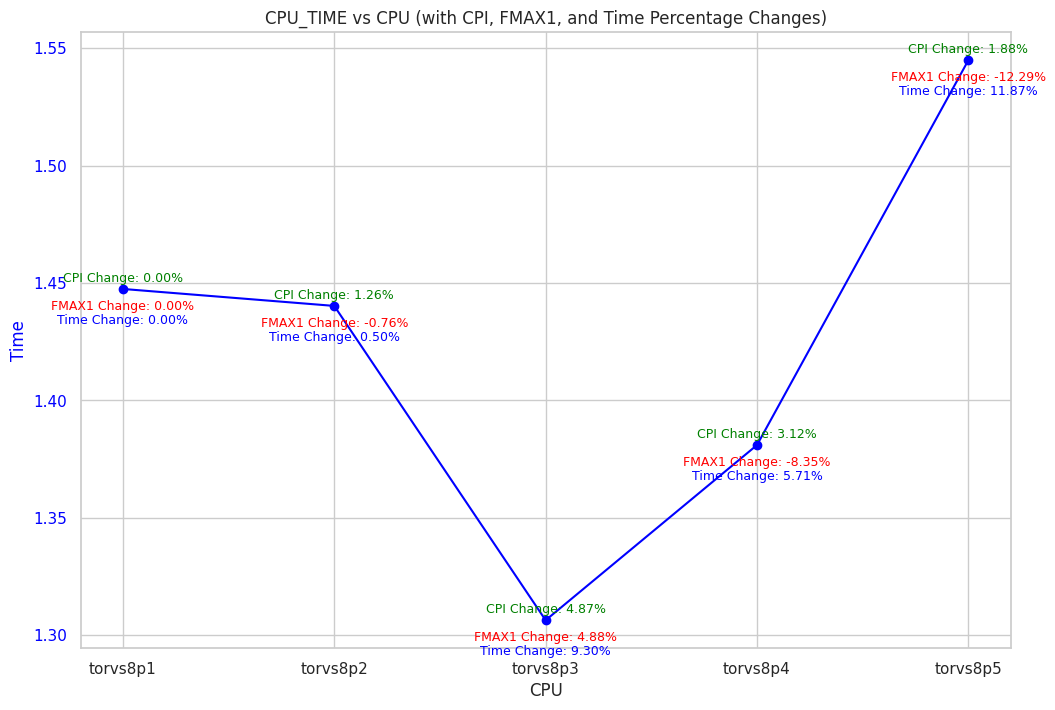

In [62]:
# Load CSV files
dfD = pd.read_csv("INFO/BENCH/TORVS/dhrystones.csv", usecols=["CPU", "CPI", "INSTRET"], nrows=10)
dfR = pd.read_csv("INFO/BENCH/TORVS/raystones.csv", usecols=["CPU", "CPI", "INSTRET"], nrows=10)
dfC = pd.read_csv("INFO/BENCH/TORVS/coremark.csv", usecols=["CPU", "CPI", "INSTRET"], nrows=10)
df0 = pd.read_csv("INFO/BOARDS/DE10S/dhrystones.csv", usecols=["CPU", "ALMs"], nrows=10)
df2 = pd.read_csv("INFO/BOARDS/DE10S/dhrystones.csv", usecols=["CPU", "FMAX1"], nrows=10)

# Compute average CPI and INSTRET across dfD, dfR, and dfC
df_avg = dfD[["CPU"]].copy()
df_avg["CPI"] = (dfD["CPI"] + dfR["CPI"] + dfC["CPI"]) / 3
df_avg["INSTRET"] = (dfD["INSTRET"] + dfR["INSTRET"] + dfC["INSTRET"]) / 3

# Calculate CPU_TIME (CPI * INSTRET) / (FMAX1 * 10^6)
df_avg["CPU_TIME"] = (df_avg["CPI"] * df_avg["INSTRET"]) / (df2["FMAX1"] * 1e6)

# Merge dataframes to include ALMs, CPI, CPU_TIME, and FMAX1
df2 = pd.merge(df2, df_avg[["CPU", "CPU_TIME", "CPI"]], on="CPU", how="inner")
data = pd.merge(df0, df2[["CPU", "CPU_TIME", "FMAX1", "CPI"]], on="CPU", how="inner")

# Filter rows where CPU starts with "torvs8p"
data = data[data["CPU"].str.startswith("torvs8p")]

# Sort the data by CPU for proper line plotting
data_sorted = data.sort_values(by="CPU")

# Calculate percentage changes in CPI, FMAX1, and CPU_TIME
data_sorted["CPI_change_pct"] = data_sorted["CPI"].pct_change().fillna(0) * 100
data_sorted["FMAX1_change_pct"] = data_sorted["FMAX1"].pct_change().fillna(0) * 100

# Modify the CPU_TIME change to make the negative percentage positive when decreasing
data_sorted["CPU_TIME_change_pct"] = data_sorted["CPU_TIME"].pct_change().fillna(0) * 100
data_sorted["CPU_TIME_change_pct"] = np.abs(data_sorted["CPU_TIME_change_pct"])

# Adjust the CPI change to consider a decrease as a positive gain
data_sorted["CPI_change_pct"] = np.abs(data_sorted["CPI_change_pct"])

# Plot the graph
fig, ax1 = plt.subplots(figsize=(12, 8))

# Plot CPU_TIME vs CPU (primary Y-axis)
ax1.plot(data_sorted["CPU"], data_sorted["CPU_TIME"], label="CPU_TIME", color="blue", marker='o')
ax1.set_xlabel("CPU")
ax1.set_ylabel("Time", color="blue")  # Changed label to "Time"
ax1.tick_params(axis='y', labelcolor="blue")

# Annotate the percentage changes in CPI (green), FMAX1 (red), and CPU_TIME (blue) at each point
for i, row in data_sorted.iterrows():
    ax1.annotate(f'CPI Change: {row["CPI_change_pct"]:.2f}%', 
                 (row["CPU"], row["CPU_TIME"]), 
                 textcoords="offset points", 
                 xytext=(0, 5), 
                 ha='center', fontsize=9, color='green')  # CPI Change in Green
    
    ax1.annotate(f'FMAX1 Change: {row["FMAX1_change_pct"]:.2f}%', 
                 (row["CPU"], row["CPU_TIME"]), 
                 textcoords="offset points", 
                 xytext=(0, -15), 
                 ha='center', fontsize=9, color='red')  # FMAX1 Change in Red
    
    ax1.annotate(f'Time Change: {row["CPU_TIME_change_pct"]:.2f}%', 
                 (row["CPU"], row["CPU_TIME"]), 
                 textcoords="offset points", 
                 xytext=(0, -25), 
                 ha='center', fontsize=9, color='blue')  # CPU_TIME Change in Blue

# Customize the plot
plt.title("CPU_TIME vs CPU (with CPI, FMAX1, and Time Percentage Changes)")
plt.grid(True)

# Save the graph to an image (optional)
fig.savefig("cpu_timeXcpu.png", format="png")

# Show the plot
plt.show()

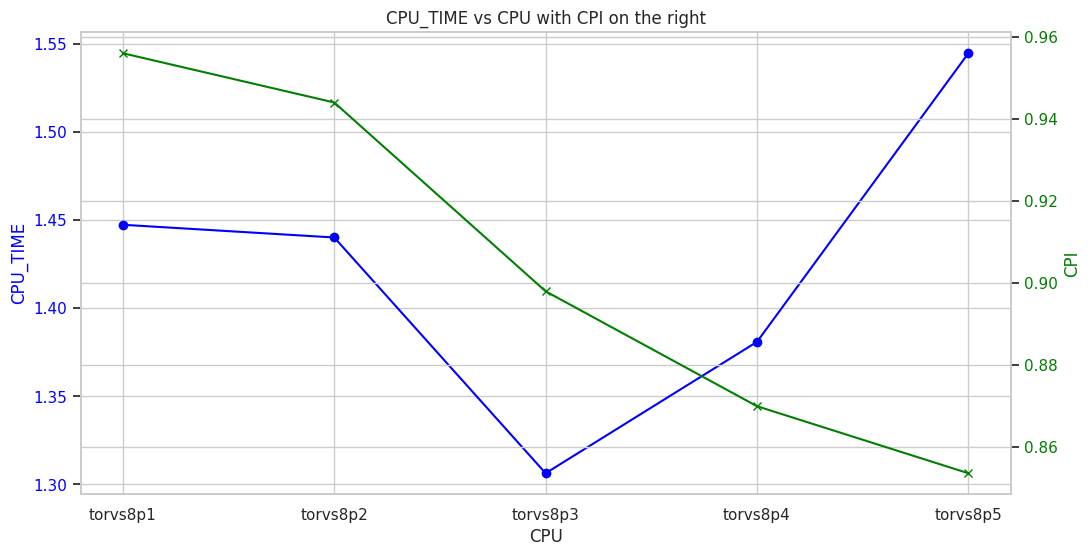

In [58]:
# Load CSV files
dfD = pd.read_csv("INFO/BENCH/TORVS/dhrystones.csv", usecols=["CPU", "CPI", "INSTRET"], nrows=10)
dfR = pd.read_csv("INFO/BENCH/TORVS/raystones.csv", usecols=["CPU", "CPI", "INSTRET"], nrows=10)
dfC = pd.read_csv("INFO/BENCH/TORVS/coremark.csv", usecols=["CPU", "CPI", "INSTRET"], nrows=10)
df0 = pd.read_csv("INFO/BOARDS/DE10S/dhrystones.csv", usecols=["CPU", "ALMs"], nrows=10)
df2 = pd.read_csv("INFO/BOARDS/DE10S/dhrystones.csv", usecols=["CPU", "FMAX1"], nrows=10)

# Compute average CPI and INSTRET across dfD, dfR, and dfC
df_avg = dfD[["CPU"]].copy()
df_avg["CPI"] = (dfD["CPI"] + dfR["CPI"] + dfC["CPI"]) / 3
df_avg["INSTRET"] = (dfD["INSTRET"] + dfR["INSTRET"] + dfC["INSTRET"]) / 3

# Calculate CPU_TIME (CPI * INSTRET) / (FMAX1 * 10^6)
df_avg["CPU_TIME"] = (df_avg["CPI"] * df_avg["INSTRET"]) / (df2["FMAX1"] * 1e6)

# Merge dataframes to include ALMs and CPU_TIME
df2 = pd.merge(df2, df_avg[["CPU", "CPU_TIME", "CPI"]], on="CPU", how="inner")
data = pd.merge(df0, df2[["CPU", "CPU_TIME", "CPI"]], on="CPU", how="inner")

# Filter rows where CPU starts with "torvs8p"
data = data[data["CPU"].str.startswith("torvs8p")]

# Sort the data by CPU for proper line plotting
data_sorted = data.sort_values(by="CPU")

# Plot the graph
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot CPU_TIME vs CPU (primary Y-axis)
ax1.plot(data_sorted["CPU"], data_sorted["CPU_TIME"], label="CPU_TIME", color="blue", marker='o')
ax1.set_xlabel("CPU")
ax1.set_ylabel("CPU_TIME", color="blue")
ax1.tick_params(axis='y', labelcolor="blue")

# Create a secondary Y-axis for CPI
ax2 = ax1.twinx()
ax2.plot(data_sorted["CPU"], data_sorted["CPI"], label="CPI", color="green", marker='x')
ax2.set_ylabel("CPI", color="green")
ax2.tick_params(axis='y', labelcolor="green")

# Customize the plot
plt.title("CPU_TIME vs CPU with CPI on the right")
plt.grid(True)
plt.show()

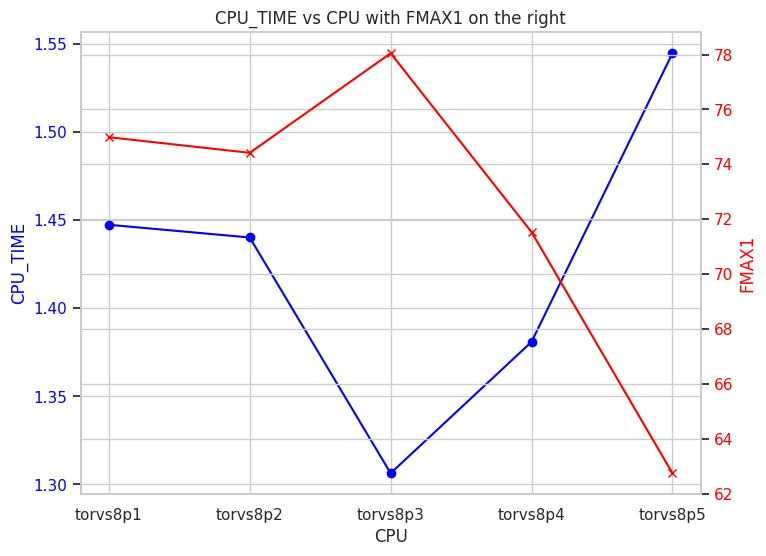

In [41]:
# Load CSV files
dfD = pd.read_csv("INFO/BENCH/TORVS/dhrystones.csv", usecols=["CPU", "CPI", "INSTRET"], nrows=10)
dfR = pd.read_csv("INFO/BENCH/TORVS/raystones.csv", usecols=["CPU", "CPI", "INSTRET"], nrows=10)
dfC = pd.read_csv("INFO/BENCH/TORVS/coremark.csv", usecols=["CPU", "CPI", "INSTRET"], nrows=10)
df0 = pd.read_csv("INFO/BOARDS/DE10S/dhrystones.csv", usecols=["CPU", "ALMs"], nrows=10)
df2 = pd.read_csv("INFO/BOARDS/DE10S/dhrystones.csv", usecols=["CPU", "FMAX1"], nrows=10)


# Compute average CPI and INSTRET across dfD, dfR, and dfC
df_avg = dfD[["CPU"]].copy()
df_avg["CPI"] = (dfD["CPI"] + dfR["CPI"] + dfC["CPI"]) / 3
df_avg["INSTRET"] = (dfD["INSTRET"] + dfR["INSTRET"] + dfC["INSTRET"]) / 3

# Calculate CPU_TIME (CPI * INSTRET) / (FMAX1 * 10^6)
df_avg["CPU_TIME"] = (df_avg["CPI"] * df_avg["INSTRET"]) / (df2["FMAX1"] * 1e6)

# Merge dataframes to include ALMs and CPU_TIME
df2 = pd.merge(df2, df_avg[["CPU", "CPU_TIME", "CPI"]], on="CPU", how="inner")
data = pd.merge(df0, df2[["CPU", "CPU_TIME", "FMAX1"]], on="CPU", how="inner")

# Filter rows where CPU starts with "torvs8p"
data = data[data["CPU"].str.startswith("torvs8p")]

# Sort the data by CPU for proper line plotting
data_sorted = data.sort_values(by="CPU")

# Plot the graph
fig, ax1 = plt.subplots(figsize=(8, 6))

# Plot CPU_TIME vs CPU (primary Y-axis)
ax1.plot(data_sorted["CPU"], data_sorted["CPU_TIME"], label="CPU_TIME", color="blue", marker='o')
ax1.set_xlabel("CPU")
ax1.set_ylabel("CPU_TIME", color="blue")
ax1.tick_params(axis='y', labelcolor="blue")

# Create a secondary Y-axis for FMAX1
ax2 = ax1.twinx()
ax2.plot(data_sorted["CPU"], data_sorted["FMAX1"], label="FMAX1", color="red", marker='x')
ax2.set_ylabel("FMAX1", color="red")
ax2.tick_params(axis='y', labelcolor="red")

# Customize the plot
plt.title("CPU_TIME vs CPU with FMAX1 on the right")
plt.grid(True)
plt.show()

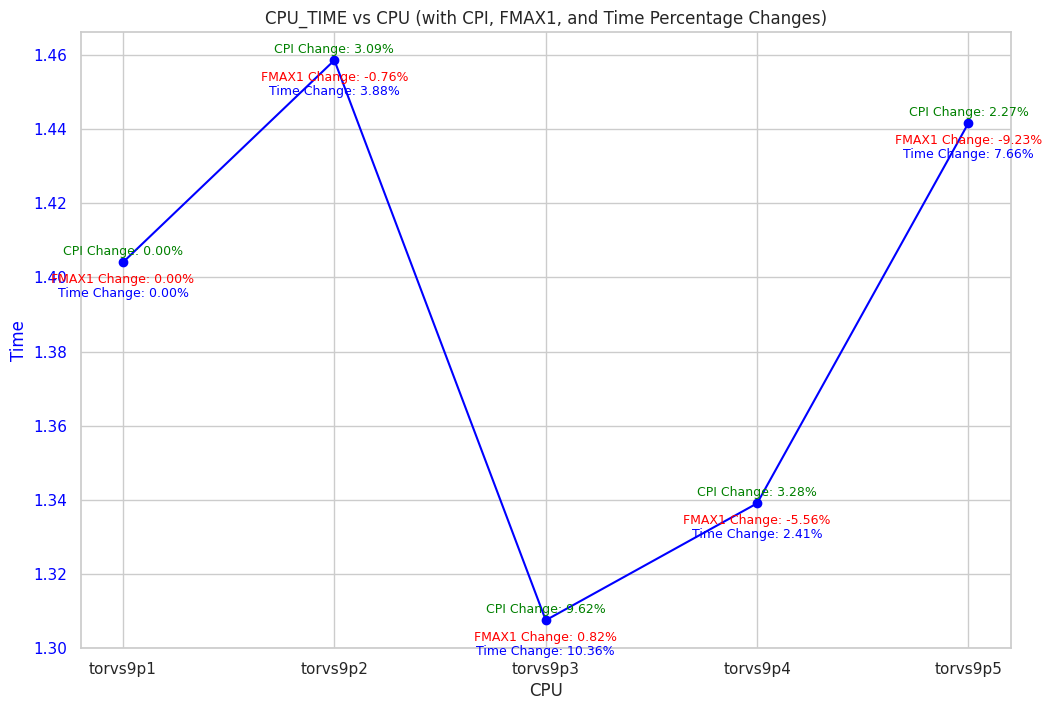

In [63]:
# Load CSV files
dfD = pd.read_csv("INFO/BENCH/TORVS/dhrystones.csv", usecols=["CPU", "CPI", "INSTRET"], nrows=10)
dfR = pd.read_csv("INFO/BENCH/TORVS/raystones.csv", usecols=["CPU", "CPI", "INSTRET"], nrows=10)
dfC = pd.read_csv("INFO/BENCH/TORVS/coremark.csv", usecols=["CPU", "CPI", "INSTRET"], nrows=10)
df0 = pd.read_csv("INFO/BOARDS/DE10S/dhrystones.csv", usecols=["CPU", "ALMs"], nrows=10)
df2 = pd.read_csv("INFO/BOARDS/DE10S/dhrystones.csv", usecols=["CPU", "FMAX1"], nrows=10)

# Compute average CPI and INSTRET across dfD, dfR, and dfC
df_avg = dfD[["CPU"]].copy()
df_avg["CPI"] = (dfD["CPI"] + dfR["CPI"] + dfC["CPI"]) / 3
df_avg["INSTRET"] = (dfD["INSTRET"] + dfR["INSTRET"] + dfC["INSTRET"]) / 3

# Calculate CPU_TIME (CPI * INSTRET) / (FMAX1 * 10^6)
df_avg["CPU_TIME"] = (df_avg["CPI"] * df_avg["INSTRET"]) / (df2["FMAX1"] * 1e6)

# Merge dataframes to include ALMs, CPI, CPU_TIME, and FMAX1
df2 = pd.merge(df2, df_avg[["CPU", "CPU_TIME", "CPI"]], on="CPU", how="inner")
data = pd.merge(df0, df2[["CPU", "CPU_TIME", "FMAX1", "CPI"]], on="CPU", how="inner")

# Filter rows where CPU starts with "torvs8p"
data = data[data["CPU"].str.startswith("torvs9p")]

# Sort the data by CPU for proper line plotting
data_sorted = data.sort_values(by="CPU")

# Calculate percentage changes in CPI, FMAX1, and CPU_TIME
data_sorted["CPI_change_pct"] = data_sorted["CPI"].pct_change().fillna(0) * 100
data_sorted["FMAX1_change_pct"] = data_sorted["FMAX1"].pct_change().fillna(0) * 100

# Modify the CPU_TIME change to make the negative percentage positive when decreasing
data_sorted["CPU_TIME_change_pct"] = data_sorted["CPU_TIME"].pct_change().fillna(0) * 100
data_sorted["CPU_TIME_change_pct"] = np.abs(data_sorted["CPU_TIME_change_pct"])

# Adjust the CPI change to consider a decrease as a positive gain
data_sorted["CPI_change_pct"] = np.abs(data_sorted["CPI_change_pct"])

# Plot the graph
fig, ax1 = plt.subplots(figsize=(12, 8))

# Plot CPU_TIME vs CPU (primary Y-axis)
ax1.plot(data_sorted["CPU"], data_sorted["CPU_TIME"], label="CPU_TIME", color="blue", marker='o')
ax1.set_xlabel("CPU")
ax1.set_ylabel("Time", color="blue")  # Changed label to "Time"
ax1.tick_params(axis='y', labelcolor="blue")

# Annotate the percentage changes in CPI (green), FMAX1 (red), and CPU_TIME (blue) at each point
for i, row in data_sorted.iterrows():
    ax1.annotate(f'CPI Change: {row["CPI_change_pct"]:.2f}%', 
                 (row["CPU"], row["CPU_TIME"]), 
                 textcoords="offset points", 
                 xytext=(0, 5), 
                 ha='center', fontsize=9, color='green')  # CPI Change in Green
    
    ax1.annotate(f'FMAX1 Change: {row["FMAX1_change_pct"]:.2f}%', 
                 (row["CPU"], row["CPU_TIME"]), 
                 textcoords="offset points", 
                 xytext=(0, -15), 
                 ha='center', fontsize=9, color='red')  # FMAX1 Change in Red
    
    ax1.annotate(f'Time Change: {row["CPU_TIME_change_pct"]:.2f}%', 
                 (row["CPU"], row["CPU_TIME"]), 
                 textcoords="offset points", 
                 xytext=(0, -25), 
                 ha='center', fontsize=9, color='blue')  # CPU_TIME Change in Blue

# Customize the plot
plt.title("CPU_TIME vs CPU (with CPI, FMAX1, and Time Percentage Changes)")
plt.grid(True)

# Save the graph to an image (optional)
fig.savefig("cpu_timeXcpu.png", format="png")

# Show the plot
plt.show()

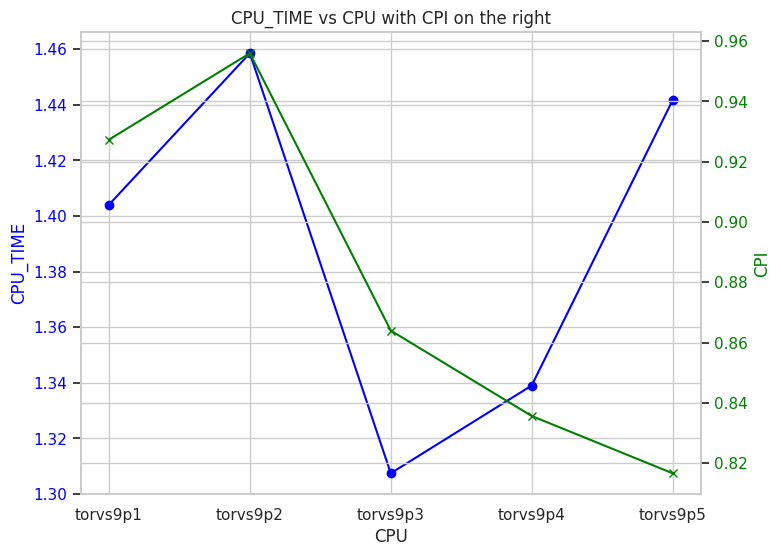

In [43]:
# Load CSV files
dfD = pd.read_csv("INFO/BENCH/TORVS/dhrystones.csv", usecols=["CPU", "CPI", "INSTRET"], nrows=10)
dfR = pd.read_csv("INFO/BENCH/TORVS/raystones.csv", usecols=["CPU", "CPI", "INSTRET"], nrows=10)
dfC = pd.read_csv("INFO/BENCH/TORVS/coremark.csv", usecols=["CPU", "CPI", "INSTRET"], nrows=10)
df0 = pd.read_csv("INFO/BOARDS/DE10S/dhrystones.csv", usecols=["CPU", "ALMs"], nrows=10)
df2 = pd.read_csv("INFO/BOARDS/DE10S/dhrystones.csv", usecols=["CPU", "FMAX1"], nrows=10)

# Compute average CPI and INSTRET across dfD, dfR, and dfC
df_avg = dfD[["CPU"]].copy()
df_avg["CPI"] = (dfD["CPI"] + dfR["CPI"] + dfC["CPI"]) / 3
df_avg["INSTRET"] = (dfD["INSTRET"] + dfR["INSTRET"] + dfC["INSTRET"]) / 3

# Calculate CPU_TIME (CPI * INSTRET) / (FMAX1 * 10^6)
df_avg["CPU_TIME"] = (df_avg["CPI"] * df_avg["INSTRET"]) / (df2["FMAX1"] * 1e6)

# Merge dataframes to include ALMs and CPU_TIME
df2 = pd.merge(df2, df_avg[["CPU", "CPU_TIME", "CPI"]], on="CPU", how="inner")
data = pd.merge(df0, df2[["CPU", "CPU_TIME", "CPI"]], on="CPU", how="inner")

# Filter rows where CPU starts with "torvs8p"
data = data[data["CPU"].str.startswith("torvs9p")]

# Sort the data by CPU for proper line plotting
data_sorted = data.sort_values(by="CPU")

# Plot the graph
fig, ax1 = plt.subplots(figsize=(8, 6))

# Plot CPU_TIME vs CPU (primary Y-axis)
ax1.plot(data_sorted["CPU"], data_sorted["CPU_TIME"], label="CPU_TIME", color="blue", marker='o')
ax1.set_xlabel("CPU")
ax1.set_ylabel("CPU_TIME", color="blue")
ax1.tick_params(axis='y', labelcolor="blue")

# Create a secondary Y-axis for CPI
ax2 = ax1.twinx()
ax2.plot(data_sorted["CPU"], data_sorted["CPI"], label="CPI", color="green", marker='x')
ax2.set_ylabel("CPI", color="green")
ax2.tick_params(axis='y', labelcolor="green")

# Customize the plot
plt.title("CPU_TIME vs CPU with CPI on the right")
plt.grid(True)
plt.show()

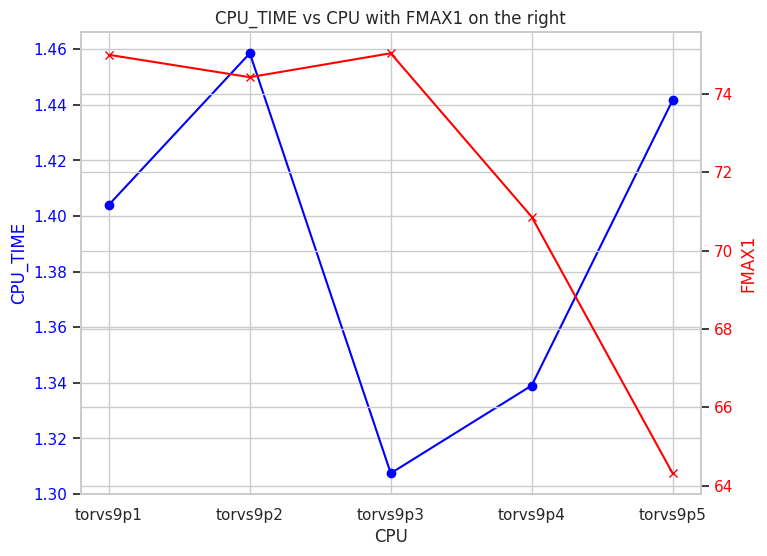

In [44]:
# Load CSV files
dfD = pd.read_csv("INFO/BENCH/TORVS/dhrystones.csv", usecols=["CPU", "CPI", "INSTRET"], nrows=10)
dfR = pd.read_csv("INFO/BENCH/TORVS/raystones.csv", usecols=["CPU", "CPI", "INSTRET"], nrows=10)
dfC = pd.read_csv("INFO/BENCH/TORVS/coremark.csv", usecols=["CPU", "CPI", "INSTRET"], nrows=10)
df0 = pd.read_csv("INFO/BOARDS/DE10S/dhrystones.csv", usecols=["CPU", "ALMs"], nrows=10)
df2 = pd.read_csv("INFO/BOARDS/DE10S/dhrystones.csv", usecols=["CPU", "FMAX1"], nrows=10)


# Compute average CPI and INSTRET across dfD, dfR, and dfC
df_avg = dfD[["CPU"]].copy()
df_avg["CPI"] = (dfD["CPI"] + dfR["CPI"] + dfC["CPI"]) / 3
df_avg["INSTRET"] = (dfD["INSTRET"] + dfR["INSTRET"] + dfC["INSTRET"]) / 3

# Calculate CPU_TIME (CPI * INSTRET) / (FMAX1 * 10^6)
df_avg["CPU_TIME"] = (df_avg["CPI"] * df_avg["INSTRET"]) / (df2["FMAX1"] * 1e6)

# Merge dataframes to include ALMs and CPU_TIME
df2 = pd.merge(df2, df_avg[["CPU", "CPU_TIME", "CPI"]], on="CPU", how="inner")
data = pd.merge(df0, df2[["CPU", "CPU_TIME", "FMAX1"]], on="CPU", how="inner")

# Filter rows where CPU starts with "torvs8p"
data = data[data["CPU"].str.startswith("torvs9p")]

# Sort the data by CPU for proper line plotting
data_sorted = data.sort_values(by="CPU")

# Plot the graph
fig, ax1 = plt.subplots(figsize=(8, 6))

# Plot CPU_TIME vs CPU (primary Y-axis)
ax1.plot(data_sorted["CPU"], data_sorted["CPU_TIME"], label="CPU_TIME", color="blue", marker='o')
ax1.set_xlabel("CPU")
ax1.set_ylabel("CPU_TIME", color="blue")
ax1.tick_params(axis='y', labelcolor="blue")

# Create a secondary Y-axis for FMAX1
ax2 = ax1.twinx()
ax2.plot(data_sorted["CPU"], data_sorted["FMAX1"], label="FMAX1", color="red", marker='x')
ax2.set_ylabel("FMAX1", color="red")
ax2.tick_params(axis='y', labelcolor="red")

# Customize the plot
plt.title("CPU_TIME vs CPU with FMAX1 on the right")
plt.grid(True)
plt.show()